# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# The Stochastic Push System when $N = 1$

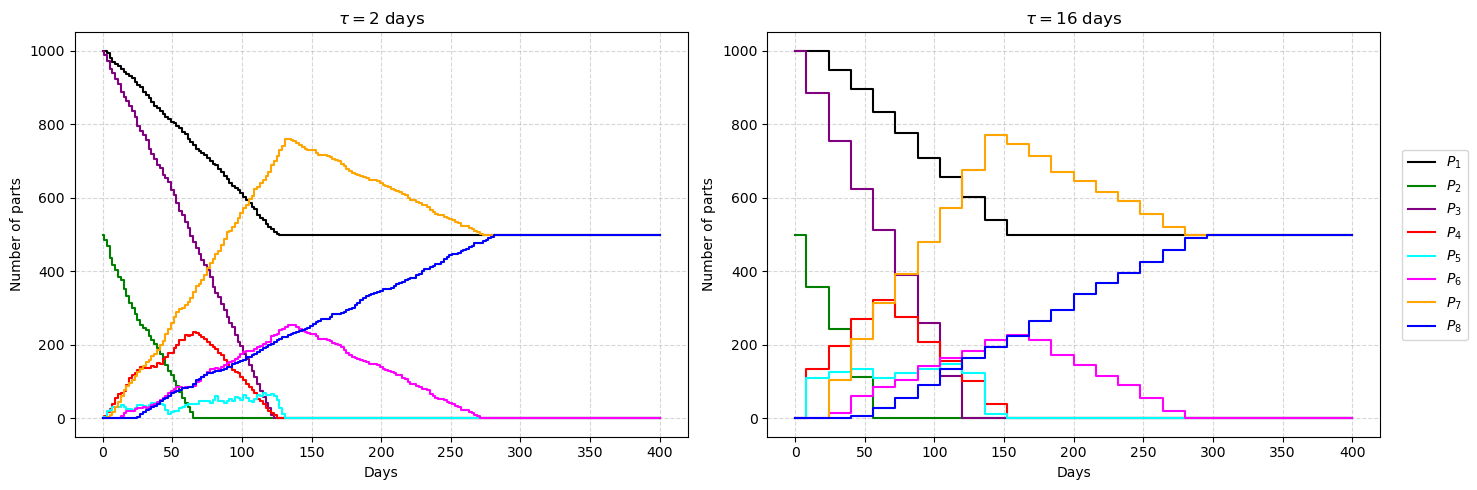

In [7]:
#######################################################################################################################
# The stochastic push system function
# The starting point for the Stochastic Push System

def stochastic_push_system(nd, J, N, T, tau, pT, C_j_c, C_j_p, lambda_j):
    Q = np.zeros(N)
    for l in range(N):
        X = np.zeros((nd, 1))
        count = 0
        X[:, count] = np.array([1000, 500, 1000, 0, 0, 0, 0, 0])
        queue_delay = []
        queue_count = 0
        t = 0

#######################################################################################################################
# Computing the Instantaneous consumption 
# Instantaneous consumption algorithm starts here
        
        while t < T:
            X = np.hstack((X, X[:, [count]]))
            Delta_C_j = np.random.poisson(lambda_j * tau)

            # Cap consumption based on available inventory
            for j in range(J):
                for i in range(nd):
                    if C_j_c[i, j] < 0:
                        max_possible = int(X[i, count + 1] / abs(C_j_c[i, j]))
                        Delta_C_j[j] = min(Delta_C_j[j], max_possible)


            X[:, count + 1] = X[:, count + 1] + C_j_c @ Delta_C_j             # Update the system

            # Create queues for the processing time, 
            for j in range(J):
                d_nq = j                                                      # Delayed index                             
                t_nq_s = t + pT[j, 0]                                         # Excution time
                Q_nq_d = Delta_C_j[j]                                         # Number of triggered process
                t_span = tau + pT[j, 1] - pT[j, 0]                            # Earliest execution time
                queue = [d_nq, t_nq_s, Q_nq_d, t_span]                        # Total execution span
                queue_delay.append(queue)
                queue_count += 1
# Instantaneous consumption algorithm ends here
#######################################################################################################################

#######################################################################################################################
# Compute the delayed production
# The delayed production algorithm Starts here
            
            if len(queue_delay) > 0:
                for d in range(len(queue_delay)):
                    d_nq, t_nq_s, Q_nq_d, t_span = queue_delay[d]
                    
                    if t_span > 0 and (t_nq_s >= t and t_nq_s < t + tau):
                        prob = min(((t + tau - t_nq_s) / t_span), 1)
                        Delta_P_j = np.random.binomial(Q_nq_d, prob)              # Number of complete process
                        Q_nq_d -= Delta_P_j                                       # Update the number of triggered process
                        t_nq_s = t + tau                                          # Update the earliest execution time
                        t_span = max(0, t_span - (t + tau - t_nq_s))              # Update the total execution span
                        
                        
                        queue_delay[d] = [d_nq, t_nq_s, Q_nq_d, t_span]           # Delayed production queue
                        
                        Delta_P_j_vec = np.zeros(J)
                        Delta_P_j_vec[d_nq] = Delta_P_j
                        X[:, count + 1] += C_j_p @ Delta_P_j_vec                  # Update the system state

            t += tau
            count += 1

        Q[l] = X[7, -1]
    return X, t, count

# The delayed production algorithm ends here
#######################################################################################################################

#######################################################################################################################
#######################################################################################################################

# Inputs
nd = 8                                     # total number of dimensions
J = 5                                      # total number of processes
N = 1                                      # number of Monte Carlo paths
T = 400                                    # Total simulation time
                                   

# Process time ranges t_min = pT[i,0], t_max = pT[i,1]
pT = np.array([[1, 1], [1, 1], [10, 10], [1, 1], [10, 10]])

# Consumption vector
C_j_c = np.array([[0, 0, -1, 0, 0],[-1, 0, 0, 0, 0],[0, -1, 0, 0, 0],[0, 0, -1, 0, 0],
    [0, 0, 0, -1, 0],[0, 0, 0, 0, -1],[0, 0, 0, 0, -1],[0, 0, 0, 0,  0]])

# Production vector
C_j_p = np.array([[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]])

# lambda_j values
lambda_j = np.array([8, 8, 4, 8, 2])

# Plot colors
colors = ['Black', 'Green', 'Purple', 'Red', 'Cyan', 'Magenta', 'Orange', 'Blue']

# Run simulation with two different taus 
taus = [2, 16]                     # time step
fig, axes = plt.subplots(1, 2, figsize=(14, 5))                    # To show the plots side-by-side

for idx, tau in enumerate(taus):
    X, t, count = stochastic_push_system(nd, J, N, T, tau, pT, C_j_c, C_j_p, lambda_j)
    time = np.arange(0, T * tau, tau)
    
    ax = axes[idx]  # Select which subplot (left or right)
    
    for i in range(nd):
        ax.step(time[:count + 1], X[i, :count + 1], where='mid', color=colors[i])

    ax.set_title(fr'$\tau = {tau}$ days')

    ax.set_xlabel('Days')
    ax.set_ylabel('Number of parts')
    ax.set_xticks(np.arange(0, T + 1, 50))                      # Set x-axis ticks with step size 50

    ax.grid(True, linestyle='--', alpha=0.5)

# Add only one legend for both plots
fig.legend([r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$', r'$P_5$', r'$P_6$', r'$P_7$', r'$P_8$'], 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


# The Stochastic Push System when $N = 100$ and the I visualized the average of the state vectors

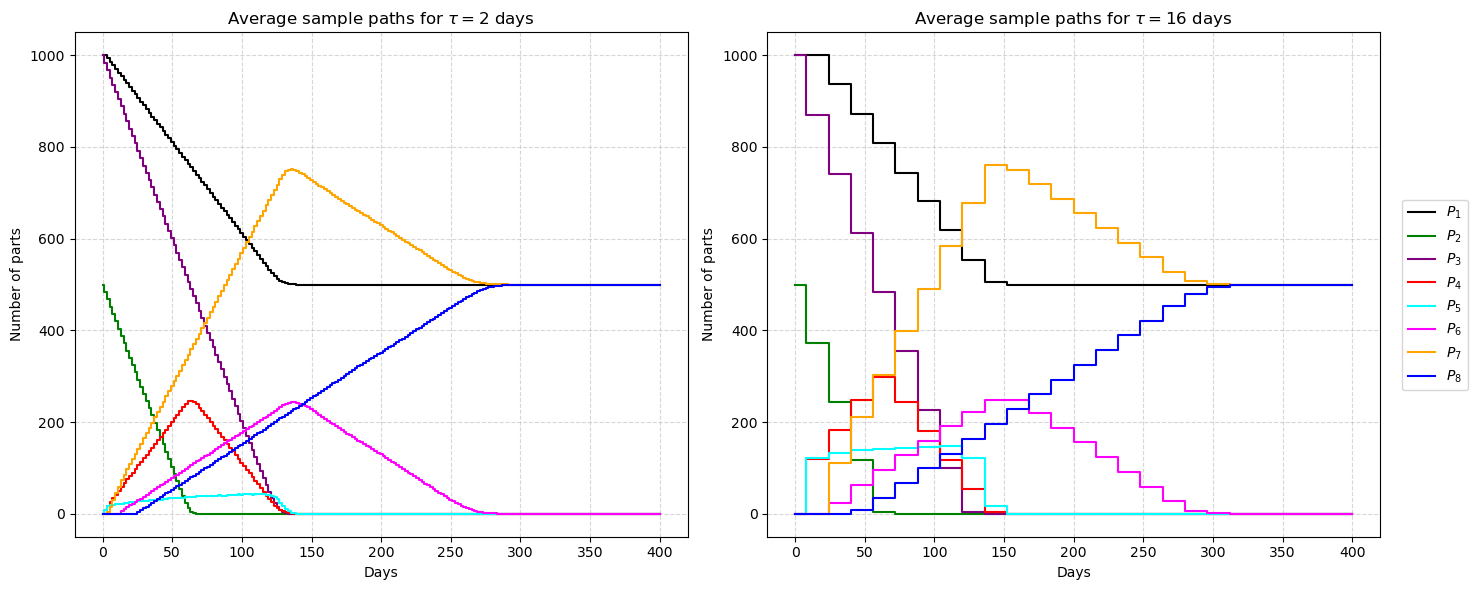

In [9]:
#######################################################################################################################
# The stochastic push system function
# The starting point for the Stochastic Push System

def stochastic_push_system(nd, J, T, tau, pT, C_j_c, C_j_p, lambda_j, N):
    time = np.arange(0, T + tau, tau)
    num_steps = len(time)
    X_all = np.zeros((N, nd, num_steps))

    for r in range(N):
        X = np.zeros((nd, num_steps))
        count = 0
        X[:, count] = np.array([1000, 500, 1000, 0, 0, 0, 0, 0])
        queue_delay = []
        queue_count = 0
        t = 0

#######################################################################################################################
# Computing the Instantaneous consumption 
# Instantaneous consumption algorithm starts here
        
        while t < T:
            X[:, count + 1] = X[:, count]
            Delta_C_j = np.random.poisson(lambda_j * tau)

            # Cap consumption based on available inventory
            for j in range(J):
                for i in range(nd):
                    if C_j_c[i, j] < 0:
                        max_possible = int(X[i, count + 1] / abs(C_j_c[i, j]))
                        Delta_C_j[j] = min(Delta_C_j[j], max_possible)

            X[:, count + 1] += C_j_c @ Delta_C_j

            for j in range(J):
                d_nq = j
                t_nq_s = t + pT[j, 0]
                Q_nq_d = Delta_C_j[j]
                t_span = tau + pT[j, 1] - pT[j, 0]
                queue_delay.append([d_nq, t_nq_s, Q_nq_d, t_span])
                queue_count += 1

# Instantaneous consumption algorithm ends here
#######################################################################################################################

#######################################################################################################################
# Compute the delayed production
# The delayed production algorithm Starts here

            if len(queue_delay) > 0:
                for d in range(len(queue_delay)):
                    d_nq, t_nq_s, Q_nq_d, t_span = queue_delay[d]
                    if t_span > 0 and (t_nq_s >= t and t_nq_s < t + tau):
                        prob = min(((t + tau - t_nq_s) / t_span), 1)
                        Delta_P_j = np.random.binomial(Q_nq_d, prob)
                        Q_nq_d -= Delta_P_j
                        t_nq_s = t + tau
                        t_span = max(0, t_span - (t + tau - t_nq_s))
                        queue_delay[d] = [d_nq, t_nq_s, Q_nq_d, t_span]

                        Delta_P_j_vec = np.zeros(J)
                        Delta_P_j_vec[d_nq] = Delta_P_j
                        X[:, count + 1] += C_j_p @ Delta_P_j_vec

            t += tau
            count += 1
# The delayed production algorithm ends here
#######################################################################################################################

        X_all[r] = X

    # Average over all runs
    X_avg = np.mean(X_all, axis=0)                # axis = 0 helps to average the state vectors  down the columns (vertically)  
    return X_avg, time

#######################################################################################################################
#######################################################################################################################

# Simulation of result
# Inputs
nd = 8                                     # total number of dimensions
J = 5                                      # total number of processes
N = 100                                     # number of Monte Carlo paths
T = 400                                    # Total simulation time
                                   

# Process time ranges t_min = pT[i,0], t_max = pT[i,1]
pT = np.array([[1, 1], [1, 1], [10, 10], [1, 1], [10, 10]])

# Consumption vector
C_j_c = np.array([[0, 0, -1, 0, 0],[-1, 0, 0, 0, 0],[0, -1, 0, 0, 0],[0, 0, -1, 0, 0],
    [0, 0, 0, -1, 0],[0, 0, 0, 0, -1],[0, 0, 0, 0, -1],[0, 0, 0, 0,  0]])

# Production vector
C_j_p = np.array([[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]])

# lambda_j values
lambda_j = np.array([8, 8, 4, 8, 2])

# Plot colors
colors = ['Black', 'Green', 'Purple', 'Red', 'Cyan', 'Magenta', 'Orange', 'Blue']


# Run simulation with two different taus 
taus = [2, 16]                     # time steps
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

for idx, tau in enumerate(taus):
    X_avg, time = stochastic_push_system(nd, J, T, tau, pT, C_j_c, C_j_p, lambda_j, N)

    
    ax = axes[idx]  # Select subplot
    
    for i in range(nd):
        ax.step(time, X_avg[i], where='mid', color=colors[i])

    ax.set_title(fr'Average sample paths for $\tau = {tau}$ days')
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of parts')
    ax.set_xticks(np.arange(0, T + 1, 50))                         # x-axis ticks with step size 50
    ax.grid(True, linestyle='--', alpha=0.5)

# Add only one legend for both plots
fig.legend([r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$', r'$P_5$', r'$P_6$', r'$P_7$', r'$P_8$'], 
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# The Stochastic Push System when $N = 100$ and the I visualized the average of the state vectors using equal and lower initial inventory levels 

# First plot 

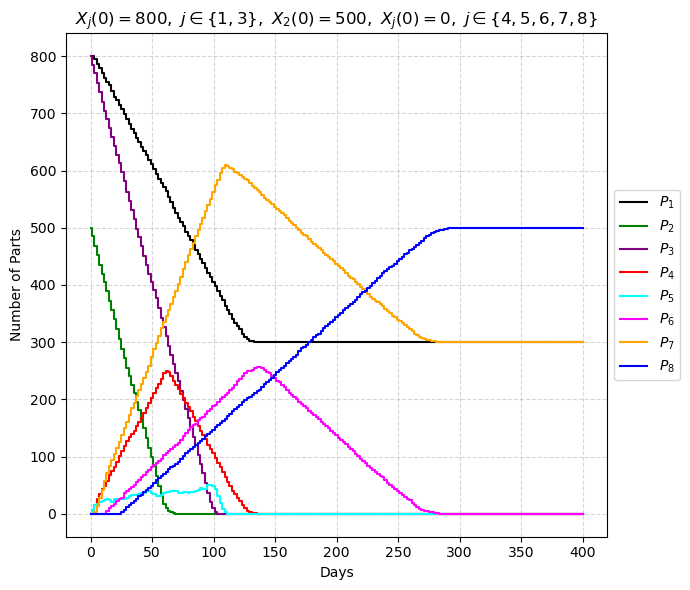

In [9]:
#######################################################################################################################
# The stochastic push system function
# The starting point for the Stochastic Push System

def stochastic_push_system(nd, J, T, tau, pT, C_j_c, C_j_p, lambda_j, N):
    time = np.arange(0, T + tau, tau)
    num_steps = len(time)
    X_all = np.zeros((N, nd, num_steps))

    for r in range(N):
        X = np.zeros((nd, num_steps))
        count = 0
        X[:, count] = np.array([800, 500, 800, 0, 0, 0, 0, 0])
        queue_delay = []
        queue_count = 0
        t = 0

#######################################################################################################################
# Computing the Instantaneous consumption 
# Instantaneous consumption algorithm starts here
        
        while t < T:
            X[:, count + 1] = X[:, count]
            Delta_C_j = np.random.poisson(lambda_j * tau)

            # Cap consumption based on available inventory
            for j in range(J):
                for i in range(nd):
                    if C_j_c[i, j] < 0:
                        max_possible = int(X[i, count + 1] / abs(C_j_c[i, j]))
                        Delta_C_j[j] = min(Delta_C_j[j], max_possible)

            X[:, count + 1] += C_j_c @ Delta_C_j

            for j in range(J):
                d_nq = j
                t_nq_s = t + pT[j, 0]
                Q_nq_d = Delta_C_j[j]
                t_span = tau + pT[j, 1] - pT[j, 0]
                queue_delay.append([d_nq, t_nq_s, Q_nq_d, t_span])
                queue_count += 1

# Instantaneous consumption algorithm ends here
#######################################################################################################################

#######################################################################################################################
# Compute the delayed production
# The delayed production algorithm Starts here

            if len(queue_delay) > 0:
                for d in range(len(queue_delay)):
                    d_nq, t_nq_s, Q_nq_d, t_span = queue_delay[d]
                    if t_span > 0 and (t_nq_s >= t and t_nq_s < t + tau):
                        K_nq = min(((t + tau - t_nq_s) / t_span), 1)
                        Delta_P_j = np.random.binomial(Q_nq_d, K_nq)
                        Q_nq_d -= Delta_P_j
                        t_nq_s = t + tau
                        t_span = max(0, t_span - (t + tau - t_nq_s))
                        queue_delay[d] = [d_nq, t_nq_s, Q_nq_d, t_span]

                        Delta_P_j_vec = np.zeros(J)
                        Delta_P_j_vec[d_nq] = Delta_P_j
                        X[:, count + 1] += C_j_p @ Delta_P_j_vec

            t += tau
            count += 1
# The delayed production algorithm ends here
#######################################################################################################################

        X_all[r] = X

    # Average over all runs
    X_avg = np.mean(X_all, axis=0)                # axis = 0 helps to average the state vectors  down the columns (vertically)  
    return X_avg, time

#######################################################################################################################
#######################################################################################################################

# Simulation of result
# Inputs
nd = 8                                     # total number of dimensions
J = 5                                      # total number of processes
N = 10                                     # number of Monte Carlo paths
T = 400                                    # Total simulation time
                                   

# Process time ranges t_min = pT[i,0], t_max = pT[i,1]
pT = np.array([[1, 1], [1, 1], [10, 10], [1, 1], [10, 10]])

# Consumption vector
C_j_c = np.array([[0, 0, -1, 0, 0],[-1, 0, 0, 0, 0],[0, -1, 0, 0, 0],[0, 0, -1, 0, 0],
    [0, 0, 0, -1, 0],[0, 0, 0, 0, -1],[0, 0, 0, 0, -1],[0, 0, 0, 0,  0]])

# Production vector
C_j_p = np.array([[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]])

# lambda_j values
lambda_j = np.array([8, 8, 4, 8, 2])

# connect_map shows the parental process and child process
# connect_map = np.array([[0, 0, 0, 1, 2, 3, 4, 5],[3, 1, 2, 3, 4, 5, 5, 0]])

# Plot colors
colors = ['Black', 'Green', 'Purple', 'Red', 'Cyan', 'Magenta', 'Orange', 'Blue']

# Run for both taus and plot averages
taus = [2]  #[2, 16]
for tau in taus:
    X_avg, time = stochastic_push_system(nd, J, T, tau, pT, C_j_c, C_j_p, lambda_j, N)

    plt.figure(figsize=(7, 6))
    for i in range(nd):
        plt.step(time, X_avg[i], where='mid', color=colors[i])

    plt.title(fr'$X_j(0) = 800,\ j \in \{{1,3\}},\ X_2(0) = 500,\ X_j(0) = 0,\ j \in \{{4,5,6,7,8\}}$')
    plt.ylabel('Number of Parts')
    plt.xlabel('Days')
    plt.xticks(np.arange(0, T + 1, 50))                          # x-axis ticks with step size 50
    plt.legend([r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$', r'$P_5$', r'$P_6$', r'$P_7$', r'$P_8$'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Second plot

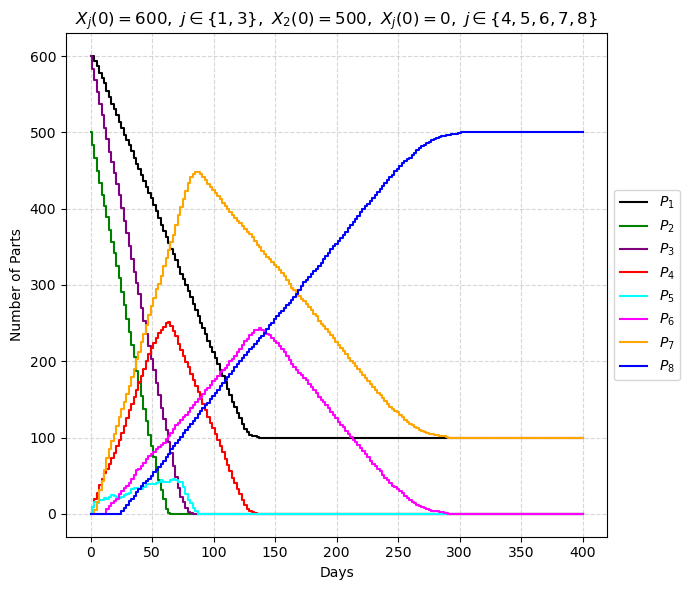

In [11]:
#######################################################################################################################
# The stochastic push system function
# The starting point for the Stochastic Push System

def stochastic_push_system(nd, J, T, tau, pT, C_j_c, C_j_p, lambda_j, N):
    time = np.arange(0, T + tau, tau)
    num_steps = len(time)
    X_all = np.zeros((N, nd, num_steps))

    for r in range(N):
        X = np.zeros((nd, num_steps))
        count = 0
        X[:, count] = np.array([600, 500, 600, 0, 0, 0, 0, 0])
        queue_delay = []
        queue_count = 0
        t = 0

#######################################################################################################################
# Computing the Instantaneous consumption 
# Instantaneous consumption algorithm starts here
        
        while t < T:
            X[:, count + 1] = X[:, count]
            Delta_C_j = np.random.poisson(lambda_j * tau)

            # Cap consumption based on available inventory
            for j in range(J):
                for i in range(nd):
                    if C_j_c[i, j] < 0:
                        max_possible = int(X[i, count + 1] / abs(C_j_c[i, j]))
                        Delta_C_j[j] = min(Delta_C_j[j], max_possible)

            X[:, count + 1] += C_j_c @ Delta_C_j

            for j in range(J):
                d_nq = j
                t_nq_s = t + pT[j, 0]
                Q_nq_d = Delta_C_j[j]
                t_span = tau + pT[j, 1] - pT[j, 0]
                queue_delay.append([d_nq, t_nq_s, Q_nq_d, t_span])
                queue_count += 1

# Instantaneous consumption algorithm ends here
#######################################################################################################################

#######################################################################################################################
# Compute the delayed production
# The delayed production algorithm Starts here

            if len(queue_delay) > 0:
                for d in range(len(queue_delay)):
                    d_nq, t_nq_s, Q_nq_d, t_span = queue_delay[d]
                    if t_span > 0 and (t_nq_s >= t and t_nq_s < t + tau):
                        K_nq = min(((t + tau - t_nq_s) / t_span), 1)
                        Delta_P_j = np.random.binomial(Q_nq_d, K_nq)
                        Q_nq_d -= Delta_P_j
                        t_nq_s = t + tau
                        t_span = max(0, t_span - (t + tau - t_nq_s))
                        queue_delay[d] = [d_nq, t_nq_s, Q_nq_d, t_span]

                        Delta_P_j_vec = np.zeros(J)
                        Delta_P_j_vec[d_nq] = Delta_P_j
                        X[:, count + 1] += C_j_p @ Delta_P_j_vec

            t += tau
            count += 1
# The delayed production algorithm ends here
#######################################################################################################################

        X_all[r] = X

    # Average over all runs
    X_avg = np.mean(X_all, axis=0)              # axis = 0 helps to average the state vectors  down the columns (vertically)  
    return X_avg, time

#######################################################################################################################
#######################################################################################################################

# Simulation of result
# Inputs
nd = 8                                     # total number of dimensions
J = 5                                      # total number of processes
N = 10                                     # number of Monte Carlo paths
T = 400                                    # Total simulation time
                                   

# Process time ranges t_min = pT[i,0], t_max = pT[i,1]
pT = np.array([[1, 1], [1, 1], [10, 10], [1, 1], [10, 10]])

# Consumption vector
C_j_c = np.array([[0, 0, -1, 0, 0],[-1, 0, 0, 0, 0],[0, -1, 0, 0, 0],[0, 0, -1, 0, 0],
    [0, 0, 0, -1, 0],[0, 0, 0, 0, -1],[0, 0, 0, 0, -1],[0, 0, 0, 0,  0]])

# Production vector
C_j_p = np.array([[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]])

# lambda_j values
lambda_j = np.array([8, 8, 4, 8, 2])

# Plot colors
colors = ['Black', 'Green', 'Purple', 'Red', 'Cyan', 'Magenta', 'Orange', 'Blue']

# Run for both taus and plot averages
taus = [2]  #[2, 16]
for tau in taus:
    X_avg, time = stochastic_push_system(nd, J, T, tau, pT, C_j_c, C_j_p, lambda_j, N)

    plt.figure(figsize=(7, 6))
    for i in range(nd):
        plt.step(time, X_avg[i], where='mid', color=colors[i])

    plt.title(fr'$X_j(0) = 600,\ j \in \{{1,3\}},\ X_2(0) = 500,\ X_j(0) = 0,\ j \in \{{4,5,6,7,8\}}$')
    plt.ylabel('Number of Parts')
    plt.xlabel('Days')
    plt.xticks(np.arange(0, T + 1, 50))                          # x-axis ticks with step size 50
    plt.legend([r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$', r'$P_5$', r'$P_6$', r'$P_7$', r'$P_8$'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Stochastic Push System with 100 MC simulations

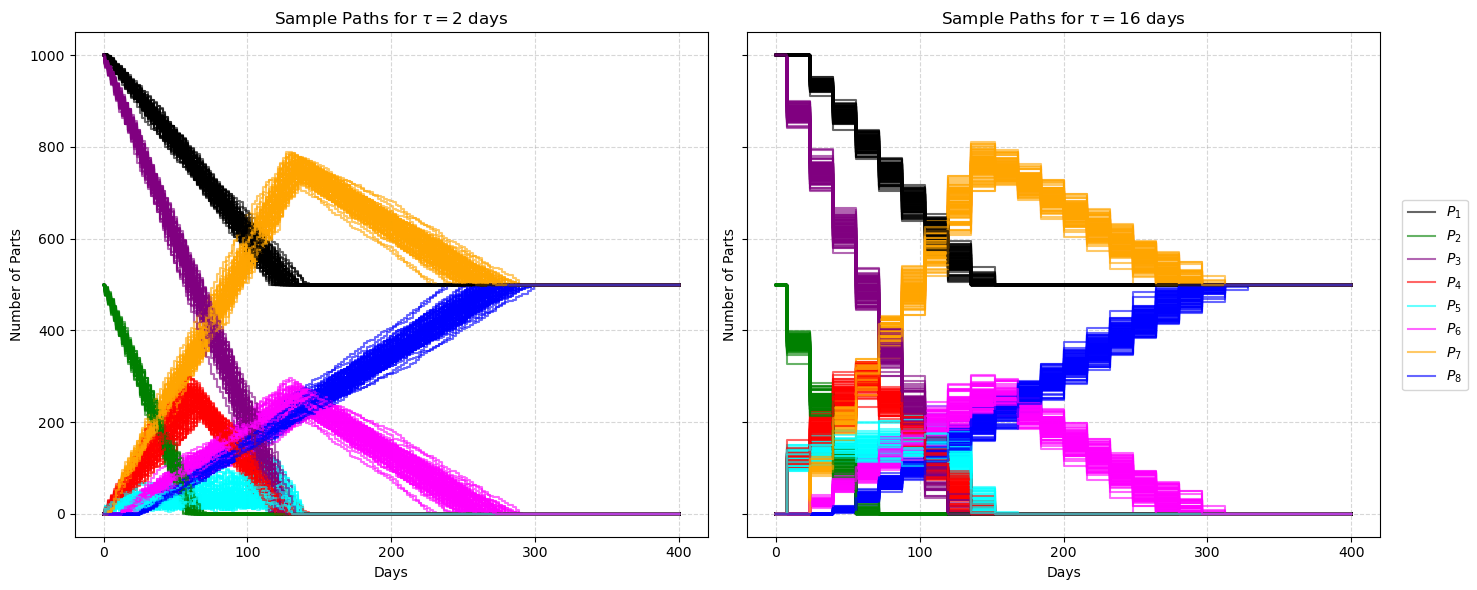

In [11]:
#######################################################################################################################
# The stochastic push system function
# The starting point for the Stochastic Push System
def stochastic_push_system(nd, J, N, T, tau, pT, C_j_c, C_j_p, lambda_j):
    time = np.arange(0, T + tau, tau)
    num_steps = len(time)

    X_all = np.zeros((N, nd, num_steps))
    Q = np.zeros(N)

    for l in range(N):
        X = np.zeros((nd, num_steps))
        count = 0
        X[:, count] = np.array([1000, 500, 1000, 0, 0, 0, 0, 0])
        queue_delay = []
        queue_count = 0
        t = 0
#######################################################################################################################
# Computing the Instantaneous consumption 
# Instantaneous consumption algorithm starts here
        
        while t < T:
            X[:, count + 1] = X[:, count]
            Delta_C_j = np.random.poisson(lambda_j * tau)

            # Cap consumption based on available inventory
            for j in range(J):
                for i in range(nd):
                    if C_j_c[i, j] < 0:
                        max_possible = int(X[i, count + 1] / abs(C_j_c[i, j]))
                        Delta_C_j[j] = min(Delta_C_j[j], max_possible)

            X[:, count + 1] += C_j_c @ Delta_C_j

            # Queues
            for j in range(J):
                d_nq = j
                t_nq_s = t + pT[j, 0]
                Q_nq_d = Delta_C_j[j]
                t_span = tau + pT[j, 1] - pT[j, 0]
                queue_delay.append([d_nq, t_nq_s, Q_nq_d, t_span])
                queue_count += 1
# Instantaneous consumption algorithm ends here
#######################################################################################################################

#######################################################################################################################
# Compute the delayed production
# The delayed production algorithm Starts here
            
            # Delayed production
            if len(queue_delay) > 0:
                for d in range(len(queue_delay)):
                    d_nq, t_nq_s, Q_nq_d, t_span = queue_delay[d]
                    if t_span > 0 and (t_nq_s >= t and t_nq_s < t + tau):
                        prob = min(((t + tau - t_nq_s) / t_span), 1)
                        Delta_P_j = np.random.binomial(Q_nq_d, prob)
                        Q_nq_d -= Delta_P_j
                        t_nq_s = t + tau
                        t_span = max(0, t_span - (t + tau - t_nq_s))
                        queue_delay[d] = [d_nq, t_nq_s, Q_nq_d, t_span]

                        Delta_P_j_vec = np.zeros(J)
                        Delta_P_j_vec[d_nq] = Delta_P_j
                        X[:, count + 1] += C_j_p @ Delta_P_j_vec

            t += tau
            count += 1
            
# The delayed production algorithm ends here
#######################################################################################################################
        
        X_all[l, :, :] = X
        Q[l] = X[7, -1]

    return X_all, time

#######################################################################################################################

# Simulation parameters
# Inputs
nd = 8                                     # total number of dimensions
J = 5                                      # total number of processes
N = 100                                     # number of Monte Carlo paths
T = 400                                    # Total simulation time
                                   

# Process time ranges t_min = pT[i,0], t_max = pT[i,1]
pT = np.array([[1, 1], [1, 1], [10, 10], [1, 1], [10, 10]])

# Consumption vector
C_j_c = np.array([[0, 0, -1, 0, 0],[-1, 0, 0, 0, 0],[0, -1, 0, 0, 0],[0, 0, -1, 0, 0],
    [0, 0, 0, -1, 0],[0, 0, 0, 0, -1],[0, 0, 0, 0, -1],[0, 0, 0, 0,  0]])

# Production vector
C_j_p = np.array([[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]])

# lambda_j values
lambda_j = np.array([8, 8, 4, 8, 2])

# Plot colors
colors = ['Black', 'Green', 'Purple', 'Red', 'Cyan', 'Magenta', 'Orange', 'Blue']


# Simulate and plot for each tau
taus = [2, 16]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # 1 row, 2 columns

for idx, tau in enumerate(taus):
    X_all, time = stochastic_push_system(nd, J, N, T, tau, pT, C_j_c, C_j_p, lambda_j)
    
    size = 100  # Number of sample trajectories to plot
    sample_indices = np.random.choice(N, size=size, replace=False)

    ax = axes[idx]  # select which subplot (left or right)

    for idx in sample_indices:
        for i in range(nd):
            ax.step(time, X_all[idx, i], where='mid', color=colors[i], alpha=0.6)

    ax.set_title(fr'Sample Paths for $\tau = {tau}$ days')
    ax.set_xlabel('Days')
    ax.set_xticks(np.arange(0, T + 1, 100))
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.set_ylabel('Number of Parts')

# Common legend
fig.legend([r'$P_1$', r'$P_2$', r'$P_3$', r'$P_4$', r'$P_5$', r'$P_6$', r'$P_7$', r'$P_8$'],
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()
